In [1]:
#this notebook is for testing when we smush 1Q gates into a 2Q gate (and changing its weyl coordinates)
# whether the new coordinates it gets access to gives the overall 2Q+smush additional volume had it not had otherwise

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import sys
sys.path.append("../../../")

import numpy as np

%matplotlib widget

from src.utils.visualize import unitary_2dlist_weyl, coordinate_2dlist_weyl
from qiskit.quantum_info import Operator
from weylchamber import c1c2c3
import h5py
#from tqdm.notebook import tqdm as tqdm
from tqdm import tqdm

filename = "/home/evm9/decomposition_EM/data/smush_unitary.h5"

In [3]:
from src.hamiltonian import ConversionGainPhaseHamiltonian
from src.basisv2 import CircuitTemplateV2
from src.utils.custom_gates import ConversionGainGate
pp =lambda p1, p2: ConversionGainGate(p1, p2, np.pi/4, np.pi/4)
basis = CircuitTemplateV2(n_qubits=2, base_gates=[pp], no_exterior_1q=0, vz_only=1)
basis.build(1)

In [18]:
t = .25
duration_1q = .1
gc = np.pi/2
gg = 0*np.pi/8
bounds_1q = 4*np.pi

# First we twirl 1Q gates, gc and gg are given as parameters

In [23]:
from src.utils.custom_gates import ConversionGainSmushGate

# NOTE first variable is tracking an offset (basically set it to 2 if counting the phase variables)
p_expand = [0, round(t/duration_1q), round(t/duration_1q)]
# XXX turn p_expand into indices is tricky

#pp2 =lambda *vargs: ConversionGainSmushGate(vargs[0], vargs[1], np.pi/2, 0, vargs[2:2+round(t/duration_1q)], vargs[2+round(t/duration_1q):], t_el=t)
pp2 =lambda *vargs: ConversionGainSmushGate(0, 0, gc, gg, vargs[:round(t/duration_1q)], vargs[round(t/duration_1q):], t_el=t)

# circuittemplate builds # of parameters by checking the number of parameters in the lambda function to build the gate
# because the parametes for gx and gy are vectors they only get counted once and it messes up
# we can add an extra parameter called param_vec_expand
# we need to use this to tell it to expand the number of parameters we should include
# however, this will get really messy because we don't know which parameters are the vectors or not
# be careful, this is going to be a mess :(
basis = CircuitTemplateV2(n_qubits=2, base_gates=[pp2], no_exterior_1q=1, vz_only=0, param_vec_expand = p_expand)
basis.build(1)
#adding constraint of 1Q params need to be positive valued
#this could be optional let's compare what happens if include it or not
for el in basis.circuit.parameters:
    s_el = str(el)
    if 'Q' in s_el:
        basis.add_bound(s_el, bounds_1q, -bounds_1q)
#basis.add_bound("Q0", 4*np.pi, 0)

100%|██████████| 1000/1000 [00:15<00:00, 64.66it/s]


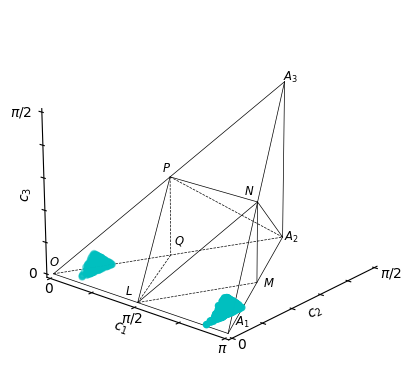

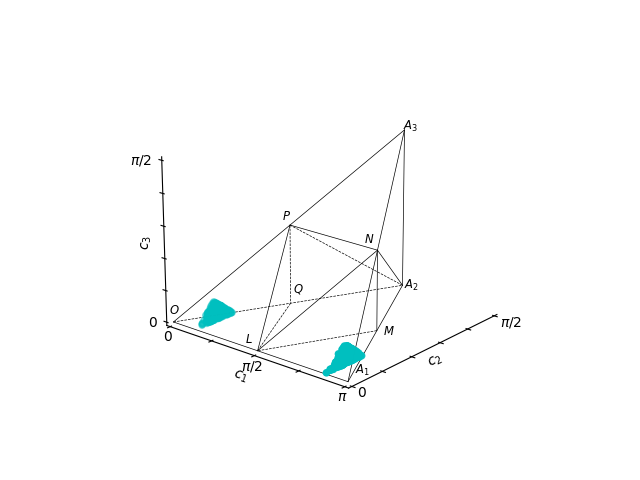

In [24]:
from src.utils.visualize import unitary_2dlist_weyl
from qiskit.quantum_info import Operator
from tqdm import tqdm
unitary_list = []
for i in tqdm(range(1000)):
    qc_init = basis.assign_Xk(basis.parameter_guess())
    unitary_list.append(Operator(qc_init).data)

unitary_2dlist_weyl(unitary_list)

# Second, we twirl 1Q gates and phase terms given the same gc,gg from (1)

In [25]:
from src.utils.custom_gates import ConversionGainSmushGate

# NOTE first variable is tracking an offset (basically set it to 2 if counting the phase variables)
p_expand = [2, round(t/duration_1q), round(t/duration_1q)]
# XXX turn p_expand into indices is tricky

pp2 =lambda *vargs: ConversionGainSmushGate(vargs[0], vargs[1], gc, gg, vargs[2:2+round(t/duration_1q)], vargs[2+round(t/duration_1q):], t_el=t)
#pp2 =lambda *vargs: ConversionGainSmushGate(0, 0, np.pi/2, 0, vargs[:round(t/du}ration_1q)], vargs[round(t/duration_1q):], t_el=t)

# circuittemplate builds # of parameters by checking the number of parameters in the lambda function to build the gate
# because the parametes for gx and gy are vectors they only get counted once and it messes up
# we can add an extra parameter called param_vec_expand
# we need to use this to tell it to expand the number of parameters we should include
# however, this will get really messy because we don't know which parameters are the vectors or not
# be careful, this is going to be a mess :(
basis = CircuitTemplateV2(n_qubits=2, base_gates=[pp2], no_exterior_1q=1, vz_only=0, param_vec_expand = p_expand)
basis.build(1)
#adding constraint of 1Q params need to be positive valued
#this could be optional let's compare what happens if include it or not
for el in basis.circuit.parameters:
    s_el = str(el)
    if 'Q' in s_el:
        basis.add_bound(s_el, bounds_1q, -bounds_1q)
#basis.add_bound("Q0", 4*np.pi, 0)
basis.circuit.draw()

┌────────────────────────────────────────────┐
q_0: ┤0                                           ├
     │  2qsmushgate(Q0,Q1,π/2,0,Q2,Q3,Q4,Q5,0.25) │
q_1: ┤1                                           ├
     └────────────────────────────────────────────┘

100%|██████████| 3000/3000 [00:54<00:00, 55.19it/s]


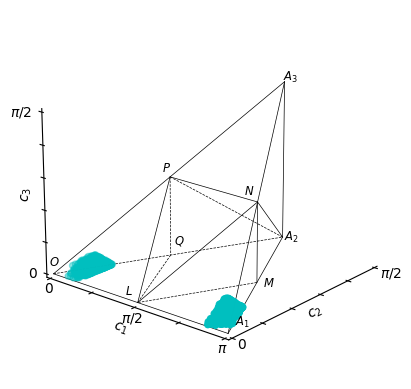

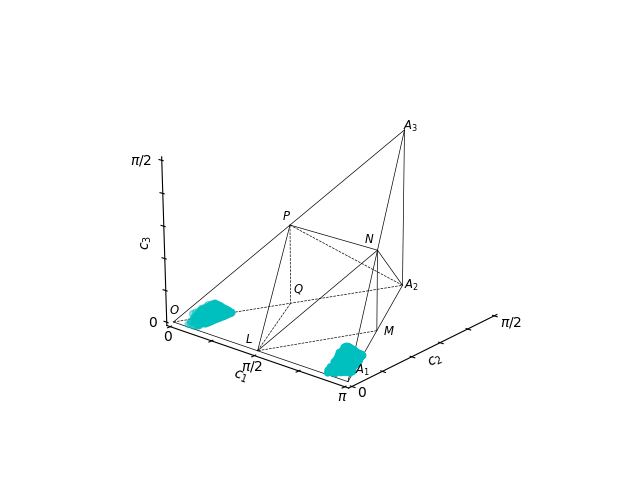

In [26]:
from src.utils.visualize import unitary_2dlist_weyl
from qiskit.quantum_info import Operator
from tqdm import tqdm
unitary_list = []

for i in tqdm(range(3000)):
    qc_init = basis.assign_Xk(basis.parameter_guess())
    unitary_list.append(Operator(qc_init).data)

unitary_2dlist_weyl(unitary_list)

# Next, we are generating points with a procedural step over gc and gg terms. 1Q and phase are twirled

In [10]:
from src.utils.custom_gates import ConversionGainSmushGate

# NOTE first variable is tracking an offset (basically set it to 2 if counting the phase variables)
p_expand = [4, round(t/duration_1q), round(t/duration_1q)]
# XXX turn p_expand into indices is tricky

pp2 =lambda *vargs: ConversionGainSmushGate(vargs[0], vargs[1], vargs[2], vargs[3], vargs[4:4+round(t/duration_1q)], vargs[4+round(t/duration_1q):], t_el=t)
#pp2 =lambda *vargs: ConversionGainSmushGate(0, 0, np.pi/2, 0, vargs[:round(t/duration_1q)], vargs[round(t/duration_1q):], t_el=t)

# circuittemplate builds # of parameters by checking the number of parameters in the lambda function to build the gate
# because the parametes for gx and gy are vectors they only get counted once and it messes up
# we can add an extra parameter called param_vec_expand
# we need to use this to tell it to expand the number of parameters we should include
# however, this will get really messy because we don't know which parameters are the vectors or not
# be careful, this is going to be a mess :(
basis = CircuitTemplateV2(n_qubits=2, base_gates=[pp2], no_exterior_1q=1, vz_only=0, param_vec_expand = p_expand)
basis.build(1)
#adding constraint of 1Q params need to be positive valued
#this could be optional let's compare what happens if include it or not
for el in basis.circuit.parameters:
    s_el = str(el)
    if 'Q' in s_el:
        basis.add_bound(s_el, bounds_1q, -bounds_1q)
basis.circuit.draw()

»
q_0: »
     »
q_1: »
     »
«     ┌───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                                                                                                      ├
«     │  2qsmushgate(Q0,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34,Q35,Q36,Q37,Q38,Q39,Q40,Q41,Q42,Q43,1) │
«q_1: ┤1                                                                                                                                                                                      ├
«     └───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [20]:
#load from hdf5 file
with h5py.File(filename, 'a') as f:
    data = f.require_group('unitary_cost_data')
    if 'unitary_list' in data and 'cost_list' in data:
        unitary_list = list(data['unitary_list'][:])
        cost_list = list(data['cost_list'][:])
    else:
        unitary_list = []
        cost_list = []

#outer loop is sweeping over gc and gc
for m in tqdm(np.linspace(0, 0.5, 5)): #17
    if m ==0:
        continue #identity is not interesting case
    
    for n in np.linspace(0, 1, 7): #21
        for i in range(10):
            
            gc = n*m*np.pi
            gg = (1-n)*m*np.pi
            cost = ConversionGainGate(0,0, gc, gg, t_el=t).cost()

            #need to convert strings to Parameter objects
            #the reason need to do this is because need to get reference to the exact parameter object via iteration
            pstrs = ["Q2", "Q3"]
            pdict = {str(pstr):[p for p in basis.circuit.parameters if p.name == pstr][0] for pstr in pstrs}

            qc_init = basis.circuit.assign_parameters({pdict["Q2"]:gc})
            qc_init = qc_init.assign_parameters({pdict["Q3"]:gg})
            #randomize the remaining parameters
            #NOTE there isn't a 1-1 mapping from p to remaining parameters bc have replaced q2 and q3 already but doesnt matter since is random
            p = basis.parameter_guess()
            #qc_init = qc_init.assign_Xk(p)
            qc_init = qc_init.assign_parameters({k:v for k,v in zip(qc_init.parameters, p)})

            #eliminating x-axis symmetry
            c = list(c1c2c3(Operator(qc_init).data))
            if c[0] > 0.5:
                c[0] = -1*c[0] + 1

            # #when checking for duplicates, keep the lower cost one
            # #instead of checking for duplicates, check if already a coordinate close by
            # if any([np.linalg.norm(np.array(c)-np.array(c2)) < 0.025 for c2 in unitary_list]):
            #     c2 = unitary_list[np.argmin([np.linalg.norm(np.array(c)-np.array(c2)) for c2 in unitary_list])]
            #     ind = unitary_list.index(c2)
            #     if cost < cost_list[ind]:
            #         unitary_list[ind] = c
            #         cost_list[ind] = cost
            #         continue
            else:        
                unitary_list.append(c)
                cost_list.append(cost)

#do some preprocessing that takes the smaller cost value if their is a match of coordinates
#no not a good idea

# save unitary list into a hdf5 file
with h5py.File(filename, 'w') as f:
    f.create_dataset('unitary_cost_data/unitary_list', data=unitary_list)
    f.create_dataset('unitary_cost_data/cost_list', data=cost_list)

100%|██████████| 5/5 [00:18<00:00,  3.74s/it]


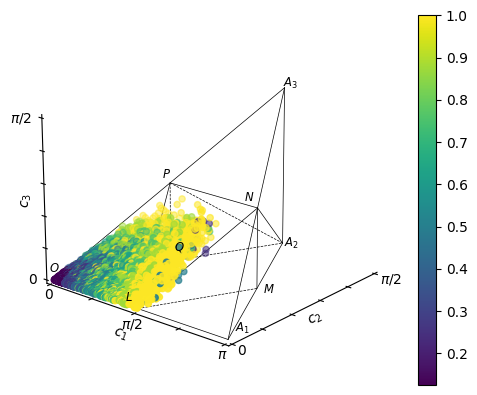

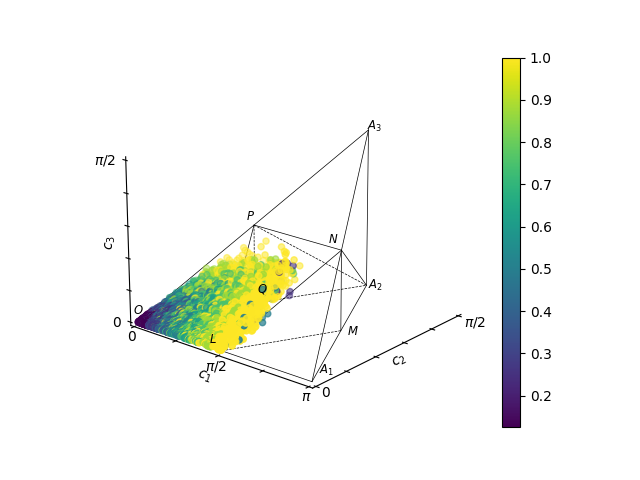

In [14]:
#load from hdf5 file
import h5py
with h5py.File(filename, 'r') as f:
    data = f.require_group('unitary_cost_data')
    if 'unitary_list' in data and 'cost_list' in data:
        unitary_list = list(data['unitary_list'][:])
        cost_list = list(data['cost_list'][:])
coordinate_2dlist_weyl(unitary_list, c=cost_list)

In [40]:
# #load from hdf5 file
# with h5py.File(filename, 'r') as f:
#     data = f.require_group('unitary_cost_data')
#     if 'unitary_list' in data and 'cost_list' in data:
#         unitary_list = list(data['unitary_list'][:])
#         cost_list = list(data['cost_list'][:])

# #if a coordinate is within some threshold of another coordinate, remove the one with the higher cost
# for i, (cost, c) in enumerate(zip(cost_list, unitary_list)):
#     #check if there is a coordinate within some threshold, not including itself
#     if any([np.linalg.norm(np.array(c)-np.array(c2)) < 0.025 for c2 in unitary_list if (c2 != c).all()]):
#         #if there is, find the index of the coordinate that is closest
#         c2 = unitary_list[np.argmin([np.linalg.norm(np.array(c)-np.array(c2)) for c2 in unitary_list if (c2 != c).all()])]
#         ind = np.where(np.all(unitary_list == c2, axis=1))[0][0]
#         #if the cost of the coordinate we are checking is higher, remove it
#         if cost > cost_list[ind]:
#             unitary_list.pop(i)
#             cost_list.pop(i)

# print(len(unitary_list))
# coordinate_2dlist_weyl(unitary_list, c=cost_list)

# Third, twirl all parameters. Unlike (3) with procedurally stepping gc and gg we guarantee the cost of gates is evenly distributed between [0,1]. If we twirl the gc and gg I want to see if there is more volume when the cost exceeds 1.

In [50]:
from src.utils.custom_gates import ConversionGainSmushGate

# NOTE first variable is tracking an offset (basically set it to 2 if counting the phase variables)
p_expand = [4, round(t/duration_1q), round(t/duration_1q)]
# XXX turn p_expand into indices is tricky

pp2 =lambda *vargs: ConversionGainSmushGate(vargs[0], vargs[1], vargs[2], vargs[3], vargs[4:4+round(t/duration_1q)], vargs[4+round(t/duration_1q):], t_el=t)
#pp2 =lambda *vargs: ConversionGainSmushGate(0, 0, np.pi/2, 0, vargs[:round(t/duration_1q)], vargs[round(t/duration_1q):], t_el=t)

# circuittemplate builds # of parameters by checking the number of parameters in the lambda function to build the gate
# because the parametes for gx and gy are vectors they only get counted once and it messes up
# we can add an extra parameter called param_vec_expand
# we need to use this to tell it to expand the number of parameters we should include
# however, this will get really messy because we don't know which parameters are the vectors or not
# be careful, this is going to be a mess :(
basis = CircuitTemplateV2(n_qubits=2, base_gates=[pp2], no_exterior_1q=1, vz_only=0, param_vec_expand = p_expand)
basis.build(1)
#adding constraint of 1Q params need to be positive valued
#this could be optional let's compare what happens if include it or not
for el in basis.circuit.parameters:
    s_el = str(el)
    if 'Q' in s_el:
        basis.add_bound(s_el, bounds_1q, -bounds_1q)
#basis.add_bound("Q0", 4*np.pi, 0)
basis.circuit.draw()

»
q_0: »
     »
q_1: »
     »
«     ┌───────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                      ├
«     │  2qsmushgate(Q0,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,1) │
«q_1: ┤1                                                                                                      ├
«     └───────────────────────────────────────────────────────────────────────────────────────────────────────┘

100%|██████████| 2500/2500 [04:54<00:00,  8.48it/s]


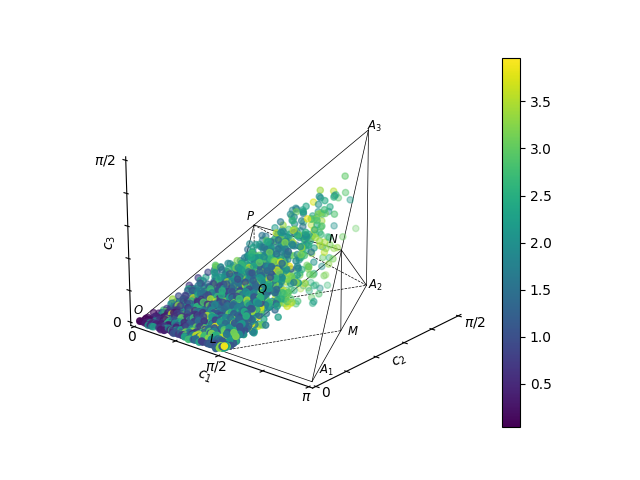

In [68]:
from src.utils.visualize import unitary_2dlist_weyl, coordinate_2dlist_weyl
from qiskit.quantum_info import Operator
from weylchamber import c1c2c3
from tqdm import tqdm
from random import random
unitary_list = []
cost_list = []


from src.utils.visualize import unitary_2dlist_weyl
from qiskit.quantum_info import Operator
from tqdm import tqdm
unitary_list = []
cost_list = []
for i in tqdm(range(2500)):

    gc = random() * np.pi
    gg = random() * np.pi
    cost = ConversionGainGate(0,0, gc, gg, t_el=t).cost()

    #need to convert strings to Parameter objects
    #the reason need to do this is because need to get reference to the exact parameter object via iteration
    pstrs = ["Q2", "Q3"]
    pdict = {str(pstr):[p for p in basis.circuit.parameters if p.name == pstr][0] for pstr in pstrs}

    qc_init = basis.circuit.assign_parameters({pdict["Q2"]:gc})
    qc_init = qc_init.assign_parameters({pdict["Q3"]:gg})
    #randomize the remaining parameters
    #NOTE there isn't a 1-1 mapping from p to remaining parameters bc have replaced q2 and q3 already but doesnt matter since is random
    p = basis.parameter_guess()
    #qc_init = qc_init.assign_Xk(p)
    qc_init = qc_init.assign_parameters({k:v for k,v in zip(qc_init.parameters, p)})

    c = list(c1c2c3(Operator(qc_init).data))

    #eliminating x-axis symmetry
    if c[0] > 0.5:
        c[0] = -1*c[0] + 1
    if c in unitary_list:
        continue

    unitary_list.append(c)
    cost_list.append(cost)

coordinate_2dlist_weyl(unitary_list, c=cost_list);

# Fourth, procedurally stepping gc and gg with no 1Q twirling or phase

In [10]:
from src.utils.custom_gates import ConversionGainSmushGate, ConversionGainGate

# NOTE first variable is tracking an offset (basically set it to 2 if counting the phase variables)
p_expand = [2,1,1]
# XXX turn p_expand into indices is tricky

pp2 =lambda *vargs: ConversionGainGate(0,0 , vargs[0], vargs[1], t_el=1.0)
#pp2 =lambda *vargs: ConversionGainSmushGate(0, 0, np.pi/2, 0, vargs[:round(t/duration_1q)], vargs[round(t/duration_1q):], t_el=t)

# circuittemplate builds # of parameters by checking the number of parameters in the lambda function to build the gate
# because the parametes for gx and gy are vectors they only get counted once and it messes up
# we can add an extra parameter called param_vec_expand
# we need to use this to tell it to expand the number of parameters we should include
# however, this will get really messy because we don't know which parameters are the vectors or not
# be careful, this is going to be a mess :(
basis = CircuitTemplateV2(n_qubits=2, base_gates=[pp2], no_exterior_1q=1, vz_only=0, param_vec_expand = p_expand)

#adding constraint of 1Q params need to be positive valued
#this could be optional let's compare what happens if include it or not
basis.build(1)
for el in basis.circuit.parameters:
    s_el = str(el)
    if 'Q' in s_el:
        basis.add_bound(s_el, bounds_1q, -bounds_1q)

#basis.add_bound("Q0", 4*np.pi, 0)
basis.circuit.draw()

┌──────────────────────┐
q_0: ┤0                     ├
     │  2qgate(0,0,Q0,Q1,1) │
q_1: ┤1                     ├
     └──────────────────────┘

100%|██████████| 27/27 [00:05<00:00,  5.17it/s]


455


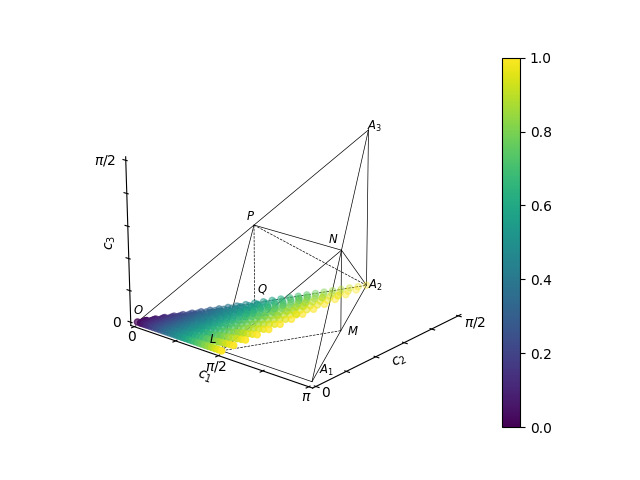

In [9]:
from src.utils.visualize import unitary_2dlist_weyl, coordinate_2dlist_weyl
from qiskit.quantum_info import Operator
from weylchamber import c1c2c3
from tqdm import tqdm
unitary_list = []
cost_list = []

#outer loop is sweeping over gc and gc
for m in tqdm(np.linspace(0,.5, 27)): #47
    for n in np.linspace(0, 1, 27): #41
        for i in range(1):

            gc = n*m*np.pi
            gg = (1-n)*m*np.pi
            cost = ConversionGainGate(0,0, gc, gg, t_el=t).cost()

            #need to convert strings to Parameter objects
            #the reason need to do this is because need to get reference to the exact parameter object via iteration
            pstrs = ["Q0", "Q1"]
            pdict = {str(pstr):[p for p in basis.circuit.parameters if p.name == pstr][0] for pstr in pstrs}

            qc_init = basis.circuit.assign_parameters({pdict["Q0"]:gc})
            qc_init = qc_init.assign_parameters({pdict["Q1"]:gg})
            #randomize the remaining parameters
            #p = basis.parameter_guess()
            #qc_init = qc_init.assign_Xk(p)

            #eliminating x-axis symmetry
            c = list(c1c2c3(Operator(qc_init).data))
            if c[0] > 0.5:
                c[0] = -1*c[0] + 1
            if c in unitary_list:
                continue

            unitary_list.append(c)
            cost_list.append(cost)

#do some preprocessing that takes the smaller cost value if their is a match of coordinates
#no not a good idea

coordinate_2dlist_weyl(unitary_list, c=cost_list);
print(len(unitary_list))

455


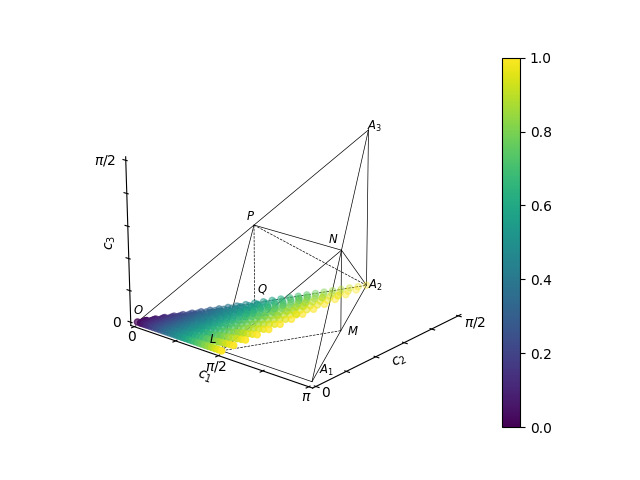

In [18]:
#if a coordinate is within some threshold of another coordinate, remove the one with the higher cost
for i, (cost, c) in enumerate(zip(cost_list, unitary_list)):
    #check if there is a coordinate within some threshold, not including itself
    if any([np.linalg.norm(np.array(c)-np.array(c2)) < 0.1 for c2 in unitary_list if (np.array(c2) != np.array(c)).all()]):
        #if there is, find the index of the coordinate that is closest
        c2 = unitary_list[np.argmin([np.linalg.norm(np.array(c)-np.array(c2)) for c2 in unitary_list if (c2 != c).all()])]
        ind = np.where(np.all(unitary_list == c2, axis=1))[0][0]
        #if the cost of the coordinate we are checking is higher, remove it
        if cost > cost_list[ind]:
            unitary_list.pop(i)
            cost_list.pop(i)

print(len(unitary_list))
coordinate_2dlist_weyl(unitary_list, c=cost_list);